In [1]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

In [2]:
from sklearn.pipeline import FeatureUnion

In [3]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Делим датасет до обработки

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [6]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

### обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

логрег был на уроке, попробую другие

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

In [8]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score:.3f} +- {cv_score_std:.3f}')

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.802 +- 0.003


In [9]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 + b ** 2) * (precision * recall) / (b ** 2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}, '
      f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
roc_auc = roc_auc_score(y_test, y_score)
print(f'roc_auc={roc_auc:.3f}')

Best Threshold=0.395, F-Score=0.740, Precision=0.698, Recall=0.788
roc_auc=0.803


In [10]:
data = [' ', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc]
columns = ['Model', 'Best Threshold', 'F-Score', 'Precision', 'Recall', 'roc_auc']      
result_df = pd.DataFrame({'Model' : ['GradientBoosting'],
                          'Best Threshold' : [thresholds[ix]],
                          'F-Score' : [fscore[ix]],
                          'Precision' : [precision[ix]],
                          'Recall' : [recall[ix]],
                          'roc_auc' : [roc_auc]}, columns=columns)
result_df

,Model,Best Threshold,F-Score,Precision,Recall,roc_auc
0,GradientBoosting,0.394947,0.740248,0.697848,0.788134,0.802615


In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score:.3f} +- {cv_score_std:.3f}')

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.774 +- 0.004


In [13]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 + b ** 2) * (precision * recall) / (b ** 2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}, '
      f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
roc_auc = roc_auc_score(y_test, y_score)
print(f'roc_auc={roc_auc:.3f}')

Best Threshold=0.350, F-Score=0.719, Precision=0.643, Recall=0.816
roc_auc=0.771


In [14]:
result_df = result_df.append({'Model' : 'RandomForest',
                          'Best Threshold' : thresholds[ix],
                          'F-Score' : fscore[ix],
                          'Precision' : precision[ix],
                          'Recall' : recall[ix],
                          'roc_auc' : roc_auc}, ignore_index=True)

In [15]:
from sklearn.ensemble import BaggingClassifier

In [16]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', BaggingClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score:.3f} +- {cv_score_std:.3f}')

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.747 +- 0.003


In [17]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 + b ** 2) * (precision * recall) / (b ** 2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}, '
      f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
roc_auc = roc_auc_score(y_test, y_score)
print(f'roc_auc={roc_auc:.3f}')

Best Threshold=0.400, F-Score=0.707, Precision=0.634, Recall=0.799
roc_auc=0.745


In [18]:
result_df = result_df.append({'Model' : 'Bagging',
                          'Best Threshold' : thresholds[ix],
                          'F-Score' : fscore[ix],
                          'Precision' : precision[ix],
                          'Recall' : recall[ix],
                          'roc_auc' : roc_auc}, ignore_index=True)

вывести сравнение полученных моделей по основным метрикам классификации

In [19]:
result_df

,Model,Best Threshold,F-Score,Precision,Recall,roc_auc
0,GradientBoosting,0.394947,0.740248,0.697848,0.788134,0.802615
1,RandomForest,0.350000,0.718863,0.642669,0.815553,0.771037
2,Bagging,0.400000,0.707310,0.634302,0.799309,0.744782


сделать выводы о том, какая модель справилась с задачей лучше других

С учетом того что речь идет про обнаружение СС болезней, нам важно не пропустить больного. То есть чем меньше FN, тем наш прогноз будет точнее. FP нас не сильно волнует, потому что если человек здоров - лишний раз пройдет проверку, ничего смертельного. Таким образом, полагаю правильным ориентироваться на Recall. Самый высокий Recall у случайного леса. 

### (опциональный вопрос)
какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).
p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). Допустим, у нас две модели:

первая помечает 100 объектов как класс 1, но TP = 90
вторая помечает 1000 объектов как класс 1, но TP такой же - 90
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [20]:
y_true = np.zeros(100000)
y_true[0:100] = 1

In [21]:
y_pred_1 = np.zeros(100000)
y_pred_1[10:110] = 1

In [22]:
y_pred_2 = np.zeros(100000)
y_pred_1[10:1010] = 1

In [23]:
from sklearn import metrics

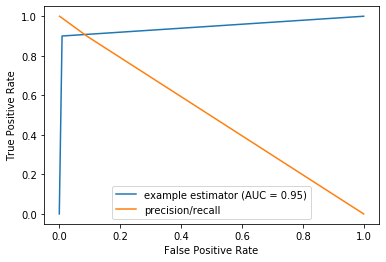

In [24]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_1)
display.plot()
plt.plot(precision, recall, label='precision/recall')
plt.legend()
plt.show()

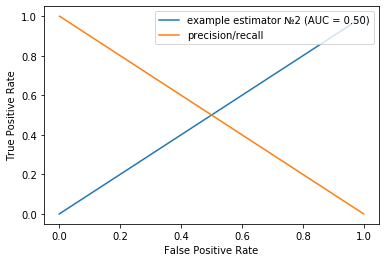

In [25]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_2)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator №2')
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_2)
display.plot()
plt.plot(precision, recall, label='precision/recall')
plt.legend()
plt.show()

Можно сделать вывод что при большом дисбалансе классов roc_auc нагляднее демонстрирует точность прогнозов модели